# Number of expected triggered hits at different energies

The normalised distributions of the number of PMTs participating in the triggering of the event for simulated muon energies of 10, 100, and 1000 PeV is displayed in this notebook (Figure 2).

This requires the file `KM3-230213A_muon_sim.root` which can be downloaded from the KM3NeT Open Data Center (see `/data` for more detail).

In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy.special import erf

# Define the file path for the dataset
fname = "../data/supplementary/simulations/KM3-230213A_muon_sim.root"

# Load the dataset from the ROOT file using uproot
combined_dataset = uproot.open(fname)['MuonEnergyEstimate'].arrays(library="pd")

The samples contains MC events over a sampling space:
  - [-20%, -15%, -10%, -5%, 0%, +5%, +10%, +15%, +20%] of absorption length
Attributing of weight of 1 to all events is assuming an uniform prior distribution over these systematics

In [2]:
# Define absorption point-to-width mapping
point_to_width = {
    80: [77.5, 82.5],
    85: [82.5, 87.5],
    90: [89, 91],
    110: [109, 111],
    115: [112.5, 117.5],
    120: [117.5, 122.4],
}

# Compute weights for absorption values using error function (erf)
weight_map = {}
for abs_value in combined_dataset.Absorption.unique():
    # Determine the range for each absorption value
    absorption_range = point_to_width.get(abs_value, [abs_value - 1, abs_value + 1])
    absorption_range = np.array(absorption_range)
    absorption_range = ((absorption_range / 100) - 1) * 10 
    
    # Compute integral weight using erf
    integral = erf(absorption_range[1]) - erf(absorption_range[0])
    weight_map[abs_value] = integral

# Apply computed weights to the dataset
combined_dataset['w_tot'] = combined_dataset.Absorption.replace(weight_map)

display(combined_dataset)

,Etrue,Edep,Absorption,NTrigPMT,w_tot
0,1.000000e+06,7.214048e+05,80.0,957,0.011866
1,1.000000e+06,1.927958e+05,80.0,272,0.011866
2,1.000000e+06,1.959326e+05,80.0,340,0.011866
3,1.000000e+06,2.746484e+05,80.0,258,0.011866
4,1.000000e+06,5.699227e+05,80.0,575,0.011866
...,...,...,...,...,...
5070568,1.000000e+09,5.619589e+08,120.0,6213,0.011793
5070569,1.000000e+09,2.728113e+08,120.0,5994,0.011793
5070570,1.000000e+09,4.769292e+08,120.0,6176,0.011793
5070571,1.000000e+09,1.670858e+08,120.0,5730,0.011793


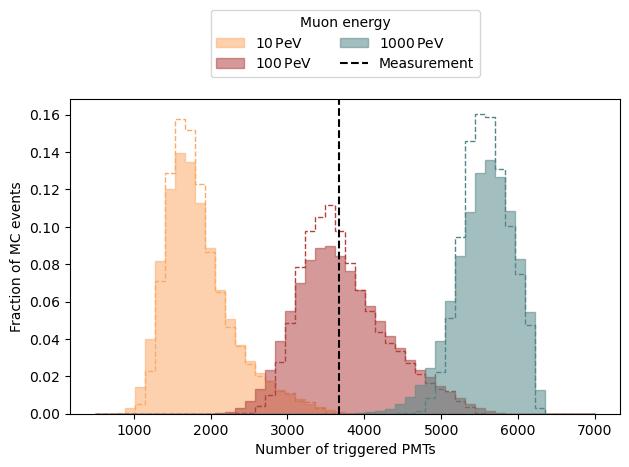

In [6]:
# Filter datasets for plotting
nb_trig_pmts_dataset = combined_dataset
colors = ["#fcaa67", "#b0413e", "#548687", "#473335"]
df_no_syst = combined_dataset[combined_dataset.Absorption == 100]
df_syst = combined_dataset

# Measured number of triggered PMTs
measure_trig_pmts = 3672

# Define energy bins and histogram bins
energies = [10, 100, 1000]
bins = np.linspace(500, 7000, 51)

# Create a figure for plotting
fig, axe = plt.subplots()
for i, E in enumerate(energies):
    color = colors[i]
    color_face = color + "88"  # Add transparency for better visualization
    
    # Select data for the current energy
    df = df_syst[df_syst.Etrue == E * 1e6]
    w = df.w_tot / np.sum(df.w_tot)
    label = f"{E:.0f}$\,$PeV"
    
    # Plot filled histogram
    axe.hist(df.NTrigPMT, weights=w, bins=bins, histtype="stepfilled", facecolor=color_face, edgecolor=color_face, label=label, zorder=i)
    
# Overlay histograms without systematic uncertainties
for i, E in enumerate(energies):
    color = colors[i]
    df = df_no_syst[df_no_syst.Etrue == E * 1e6]
    w = df.w_tot / np.sum(df.w_tot)
    label = f"{E:.0f}$\,$PeV (no syst.)"
    
    # Plot step histogram with dashed lines
    axe.hist(df.NTrigPMT, weights=w, bins=bins, histtype="step", edgecolor=color, linestyle="--", zorder=i)
    
# Add a vertical line for measured value
axe.axvline(measure_trig_pmts, color="k", label="Measurement", linestyle="--")

# Configure legend, labels, and layout
axe.legend(ncol=2, bbox_to_anchor=(0.5, 1.05), loc='lower center', title="Muon energy")
axe.set_xlabel('Number of triggered PMTs')
axe.set_ylabel("Fraction of MC events")
plt.tight_layout()
plt.show()